<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Fractal_Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


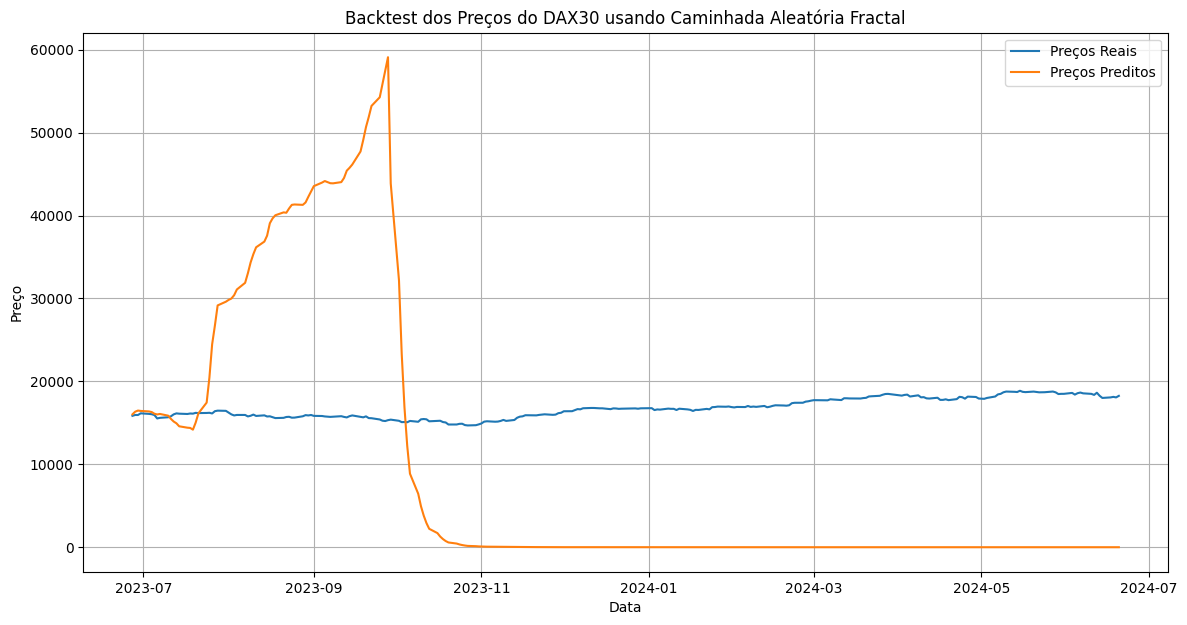

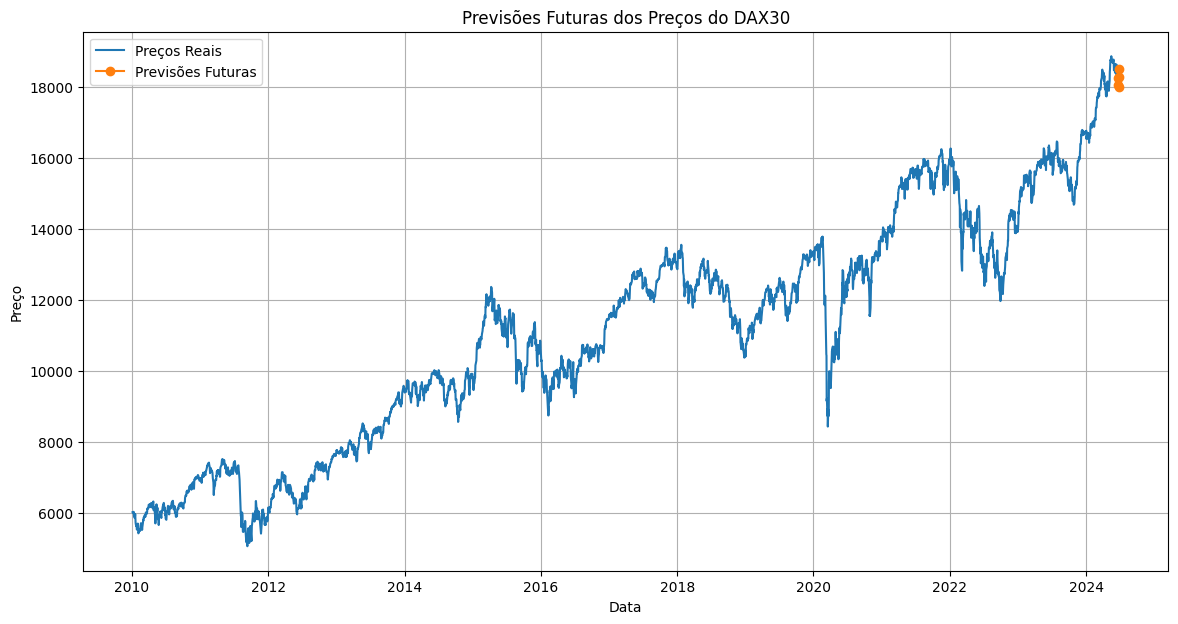

Sinais de Compra e Venda para os Próximos 5 Dias:
            PredictedPrice  Signal
2024-06-21    18250.873749      -1
2024-06-22    18060.331788      -1
2024-06-23    17995.464869      -1
2024-06-24    18272.862896       1
2024-06-25    18502.864594       1


In [4]:
# Importar bibliotecas necessárias
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import levy_stable
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Baixar dados históricos do DAX30
ticker = "^GDAXI"
data = yf.download(ticker, start="2010-01-01", end=datetime.now().strftime('%Y-%m-%d'))

# Função para modelar a caminhada aleatória fractal
def fractal_random_walk(n_steps, alpha=1.5, beta=0, scale=1):
    steps = levy_stable.rvs(alpha, beta, scale=scale, size=n_steps)
    return np.cumsum(steps)

# Calcular log-retornos
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# Treinar o modelo linear para ajustar a caminhada aleatória fractal
X = np.arange(len(data)).reshape(-1, 1)
y = data['LogReturn'].values

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

# Gerar caminhada aleatória fractal ajustada ao log-retorno
n_steps = 5  # número de dias para prever
alpha, beta, scale = 1.5, 0, np.std(y - trend)
fractal_walk = fractal_random_walk(n_steps, alpha, beta, scale)

# Prever preços futuros
last_price = data['Close'].iloc[-1]
predicted_log_returns = trend[-1] + fractal_walk
predicted_prices = last_price * np.exp(np.cumsum(predicted_log_returns))

# Fazer backtest
backtest_days = 252  # um ano de dados para backtest
backtest_data = data[-backtest_days:]
backtest_returns = backtest_data['LogReturn'].values
backtest_prices = backtest_data['Close'].values

predicted_log_returns_backtest = model.predict(np.arange(len(backtest_data)).reshape(-1, 1)) + fractal_random_walk(len(backtest_data), alpha, beta, np.std(backtest_returns))
predicted_prices_backtest = backtest_prices[0] * np.exp(np.cumsum(predicted_log_returns_backtest))

# Plotar resultados
plt.figure(figsize=(14, 7))
plt.plot(data.index[-backtest_days:], backtest_prices, label="Preços Reais")
plt.plot(data.index[-backtest_days:], predicted_prices_backtest, label="Preços Preditos")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Backtest dos Preços do DAX30 usando Caminhada Aleatória Fractal")
plt.legend()
plt.grid(True)
plt.show()

# Plotar previsões futuras
future_dates = [data.index[-1] + timedelta(days=i) for i in range(1, n_steps + 1)]
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label="Preços Reais")
plt.plot(future_dates, predicted_prices, label="Previsões Futuras", marker='o')
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Previsões Futuras dos Preços do DAX30")
plt.legend()
plt.grid(True)
plt.show()

# Gerar sinais de compra e venda
signals = pd.DataFrame(index=future_dates, data=predicted_prices, columns=['PredictedPrice'])
signals['Signal'] = 0
signals.loc[signals['PredictedPrice'] > last_price, 'Signal'] = 1  # Compra
signals.loc[signals['PredictedPrice'] < last_price, 'Signal'] = -1  # Venda

print("Sinais de Compra e Venda para os Próximos 5 Dias:")
print(signals)

# Salvar sinais em um arquivo CSV
signals.to_csv("trade_signals.csv")
